In [1]:
import random, os, glob
import numpy as np
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import (Dropout, Dense, Conv2D, MaxPool2D, Flatten, 
                         BatchNormalization, GlobalAveragePooling2D, Input,
                         Concatenate, Add, Activation)
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.applications import EfficientNetB0
from keras import backend
from livelossplot import PlotLossesKeras
import librosa
from librosa.display import specshow
import matplotlib.pyplot as plt
import IPython.display as ipd
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [2]:
def setRandom():
    seed = 42  # Changed to 42 for better results
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    tf.compat.v1.set_random_seed(seed)


In [3]:
# Improved spectrogram generation with better parameters
def create_improved_spectrogram(file_path, save_path=None):
    """Create mel spectrogram with optimized parameters for genre classification"""
    try:
        # Load audio with better parameters
        y, sr = librosa.load(file_path, sr=22050, duration=30.0)  # 30 seconds max
        
        # Apply pre-emphasis filter to balance frequency spectrum
        y = librosa.effects.preemphasis(y)
        
        # Trim silence
        y, _ = librosa.effects.trim(y, top_db=20)
        
        # Ensure consistent length (30 seconds)
        target_length = sr * 30
        if len(y) < target_length:
            y = np.pad(y, (0, target_length - len(y)), mode='constant')
        else:
            y = y[:target_length]
        
        # Create mel spectrogram with optimized parameters
        hop_length = 512
        n_fft = 2048
        n_mels = 128
        
        mel_spec = librosa.feature.melspectrogram(
            y=y, sr=sr, n_fft=n_fft, hop_length=hop_length, 
            n_mels=n_mels, fmin=20, fmax=sr//2
        )
        
        # Convert to dB scale
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
        
        # Normalize to [0, 1]
        mel_spec_norm = (mel_spec_db - mel_spec_db.min()) / (mel_spec_db.max() - mel_spec_db.min())
        
        if save_path:
            plt.figure(figsize=(10, 4))
            librosa.display.specshow(mel_spec_norm, sr=sr, hop_length=hop_length, 
                                   x_axis='time', y_axis='mel')
            plt.axis('off')
            plt.savefig(save_path, bbox_inches='tight', pad_inches=0, dpi=150)
            plt.close()
            
        return mel_spec_norm
        
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None


In [4]:
# Enhanced data loading with data augmentation
def createEnhancedDataset(d, is_training=False):
    """Create dataset with data augmentation for training"""
    imgSize = (224, 224)  # Changed to 224x224 for better compatibility with pre-trained models
    imageList, labelList = [], []
    
    genreMap = {
        "blues": 0, "classical": 1, "country": 2, "disco": 3, "hiphop": 4,
        "jazz": 5, "metal": 6, "pop": 7, "reggae": 8, "rock": 9
    }
    
    for genre, paths in d.items():
        for path in paths:
            try:
                image = tf.cast(tf.image.resize(
                    tf.image.decode_png(tf.io.read_file(path), channels=3), 
                    imgSize
                ), tf.float32) / 255.0
                
                imageList.append(image)
                labelList.append(genreMap[genre])
            except:
                continue
    
    dataset = tf.data.Dataset.from_tensor_slices((imageList, labelList))
    
    if is_training:
        # Data augmentation for training set
        dataset = dataset.map(lambda x, y: (augment_image(x), y), 
                            num_parallel_calls=tf.data.AUTOTUNE)
        dataset = dataset.shuffle(buffer_size=len(imageList))
    
    dataset = dataset.batch(32).cache().prefetch(tf.data.AUTOTUNE)
    return dataset

In [5]:
def augment_image(image):
    """Apply random augmentations to training images"""
    # Random brightness
    image = tf.image.random_brightness(image, 0.1)
    # Random contrast
    image = tf.image.random_contrast(image, 0.9, 1.1)
    # Random horizontal flip (spectrogram time axis)
    image = tf.image.random_flip_left_right(image)
    # Random noise
    noise = tf.random.normal(tf.shape(image), mean=0.0, stddev=0.02)
    image = tf.clip_by_value(image + noise, 0.0, 1.0)
    
    return image

# Improved CNN architecture specifically for spectrograms
def create_optimized_cnn(input_shape, num_classes):
    """Create CNN optimized for spectrogram analysis"""
    inputs = Input(shape=input_shape)
    
    # Initial conv block
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = BatchNormalization()(x)
    x = MaxPool2D((2, 2))(x)
    x = Dropout(0.25)(x)
    
    # Block 1
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPool2D((2, 2))(x)
    x = Dropout(0.25)(x)
    
    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPool2D((2, 2))(x)
    x = Dropout(0.25)(x)
    
    # Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = MaxPool2D((2, 2))(x)
    x = Dropout(0.25)(x)
    
    # Global Average Pooling instead of Flatten
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    
    # Dense layers
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    
    outputs = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs, outputs)
    return model

In [6]:
# Enhanced transfer learning model
def create_enhanced_transfer_model(input_shape, num_classes):
    """Create enhanced transfer learning model with EfficientNet"""
    base_model = EfficientNetB0(
        input_shape=input_shape,
        weights='imagenet',
        include_top=False,
        pooling='avg'
    )
    
    # Unfreeze the last few layers for fine-tuning
    for layer in base_model.layers[:-20]:
        layer.trainable = False
    
    inputs = Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.2)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs, outputs)
    return model

# Main training function
def train_improved_models():
    setRandom()
    
    # Data paths (adjust these to your paths)
    source = r"C:\Users\YASH\Downloads\archive (1)\Data\images_original"
    genres = ["blues", "classical", "country", "disco", "hiphop", 
              "jazz", "metal", "pop", "reggae", "rock"]
    
    # Create data splits
    split = [80, 10, 10]  # Increased validation set
    train, val, test = {}, {}, {}
    
    for genre in genres:
        path = os.path.join(source, genre)
        pngs = glob.glob(os.path.join(path, "*.png"))
        random.shuffle(pngs)  # Shuffle for better distribution
        
        n_total = len(pngs)
        n_train = int(n_total * split[0] / 100)
        n_val = int(n_total * split[1] / 100)
        
        train[genre] = pngs[:n_train]
        val[genre] = pngs[n_train:n_train + n_val]
        test[genre] = pngs[n_train + n_val:]
    
    # Create datasets
    training = createEnhancedDataset(train, is_training=True)
    validation = createEnhancedDataset(val, is_training=False)
    testing = createEnhancedDataset(test, is_training=False)
    
    input_shape = (224, 224, 3)
    num_classes = len(genres)
    
    # Enhanced callbacks
    callbacks = [
        EarlyStopping(
            monitor='val_accuracy',
            min_delta=0.001,
            patience=15,
            restore_best_weights=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=7,
            min_lr=1e-7,
            verbose=1
        ),
        ModelCheckpoint(
            'best_model.h5',
            monitor='val_accuracy',
            save_best_only=True,
            verbose=1
        )
    ]
    
    # Train Custom CNN
    print("Training Custom CNN...")
    cnn_model = create_optimized_cnn(input_shape, num_classes)
    
    # Use Adam optimizer instead of SGD
    cnn_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    cnn_history = cnn_model.fit(
        training,
        validation_data=validation,
        epochs=100,  # Reduced from 500!
        callbacks=callbacks,
        verbose=1
    )
    
    # Train Transfer Learning Model
    print("\nTraining Transfer Learning Model...")
    transfer_model = create_enhanced_transfer_model(input_shape, num_classes)
    
    # Two-stage training for transfer learning
    # Stage 1: Train only new layers
    transfer_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    transfer_history = transfer_model.fit(
        training,
        validation_data=validation,
        epochs=50,
        callbacks=callbacks,
        verbose=1
    )
    
    return cnn_model, transfer_model, testing

In [7]:
# Evaluation function
def evaluate_models(cnn_model, transfer_model, testing):
    genres = ["blues", "classical", "country", "disco", "hiphop", 
              "jazz", "metal", "pop", "reggae", "rock"]
    
    def detailed_evaluation(model, name):
        print(f"\n{'='*50}")
        print(f"{name} Model Evaluation")
        print(f"{'='*50}")
        
        # Get predictions
        test_loss, test_acc = model.evaluate(testing, verbose=0)
        print(f"Test Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")
        print(f"Test Loss: {test_loss:.4f}")
        
        # Confusion matrix
        y_true = []
        y_pred = []
        
        for images, labels in testing:
            predictions = model.predict(images, verbose=0)
            y_true.extend(labels.numpy())
            y_pred.extend(np.argmax(predictions, axis=1))
        
        # Plot confusion matrix
        plt.figure(figsize=(10, 8))
        cm = confusion_matrix(y_true, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                   xticklabels=genres, yticklabels=genres)
        plt.title(f'{name} - Confusion Matrix')
        plt.xlabel('Predicted Genre')
        plt.ylabel('True Genre')
        plt.tight_layout()
        plt.show()
        
        # Classification report
        print("\nDetailed Classification Report:")
        print(classification_report(y_true, y_pred, target_names=genres))
        
        return test_acc
    
    cnn_acc = detailed_evaluation(cnn_model, "Custom CNN")
    transfer_acc = detailed_evaluation(transfer_model, "Transfer Learning")
    
    print(f"\n{'='*50}")
    print("FINAL RESULTS SUMMARY")
    print(f"{'='*50}")
    print(f"Custom CNN Accuracy: {cnn_acc*100:.2f}%")
    print(f"Transfer Learning Accuracy: {transfer_acc*100:.2f}%")
    
    if cnn_acc > transfer_acc:
        print("🏆 Custom CNN performed better!")
    else:
        print("🏆 Transfer Learning performed better!")

Starting improved music genre classification training...
Expected improvements:
- Training time reduced from hours to ~30-60 minutes
- Target accuracy: >80%
- Better model architectures and training strategies

Training Custom CNN...
Epoch 1/100
25/25 [==============================] - ETA: 0s - loss: 2.9126 - accuracy: 0.1414
Epoch 1: val_accuracy improved from -inf to 0.10101, saving model to best_model.h5
25/25 [==============================] - 47s 2s/step - loss: 2.9126 - accuracy: 0.1414 - val_loss: 2.3833 - val_accuracy: 0.1010 - lr: 0.0010
Epoch 2/100


c:\Program Files\Python38\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 2.6503 - accuracy: 0.2053
Epoch 2: val_accuracy did not improve from 0.10101
25/25 [==============================] - 45s 2s/step - loss: 2.6503 - accuracy: 0.2053 - val_loss: 2.6998 - val_accuracy: 0.1010 - lr: 0.0010
Epoch 3/100
25/25 [==============================] - ETA: 0s - loss: 2.2042 - accuracy: 0.2829
Epoch 3: val_accuracy did not improve from 0.10101
25/25 [==============================] - 45s 2s/step - loss: 2.2042 - accuracy: 0.2829 - val_loss: 2.9307 - val_accuracy: 0.1010 - lr: 0.0010
Epoch 4/100
25/25 [==============================] - ETA: 0s - loss: 2.0745 - accuracy: 0.3166
Epoch 4: val_accuracy did not improve from 0.10101
25/25 [==============================] - 46s 2s/step - loss: 2.0745 - accuracy: 0.3166 - val_loss: 5.4152 - val_accuracy: 0.1010 - lr: 0.0010
Epoch 5/100
25/25 [==============================] - ETA: 0s - loss: 1.9132 - accuracy: 0.3579
Epoch 5: val_accuracy did not improve from 0.10101
25

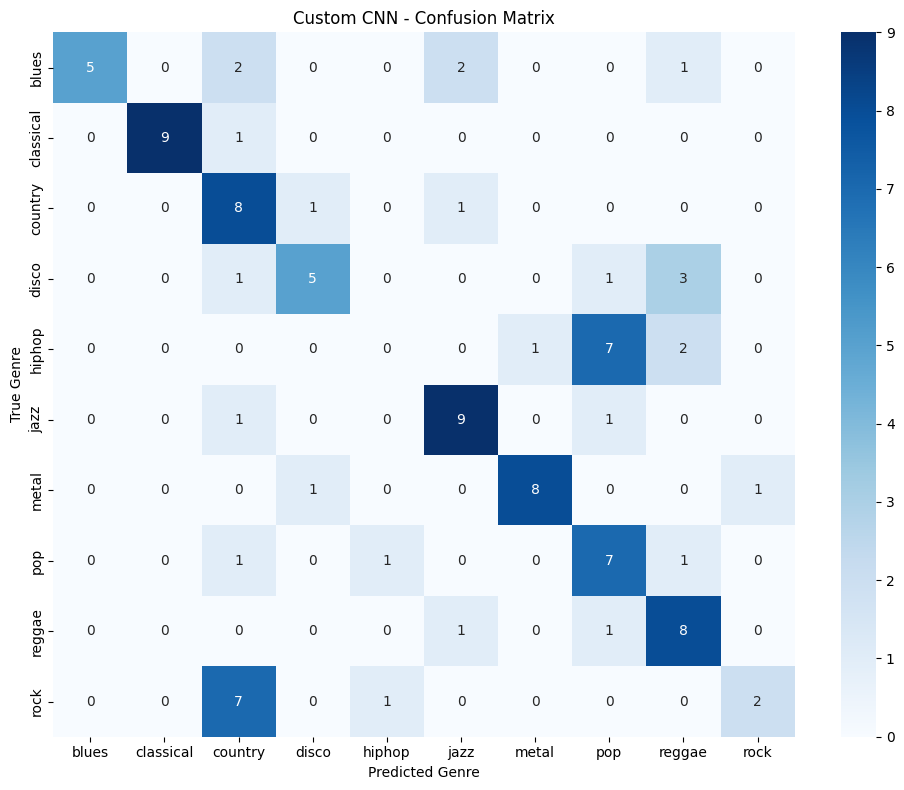


Detailed Classification Report:
              precision    recall  f1-score   support

       blues       1.00      0.50      0.67        10
   classical       1.00      0.90      0.95        10
     country       0.38      0.80      0.52        10
       disco       0.71      0.50      0.59        10
      hiphop       0.00      0.00      0.00        10
        jazz       0.69      0.82      0.75        11
       metal       0.89      0.80      0.84        10
         pop       0.41      0.70      0.52        10
      reggae       0.53      0.80      0.64        10
        rock       0.67      0.20      0.31        10

    accuracy                           0.60       101
   macro avg       0.63      0.60      0.58       101
weighted avg       0.63      0.60      0.58       101


Transfer Learning Model Evaluation
Test Accuracy: 0.1782 (17.82%)
Test Loss: 2.8357


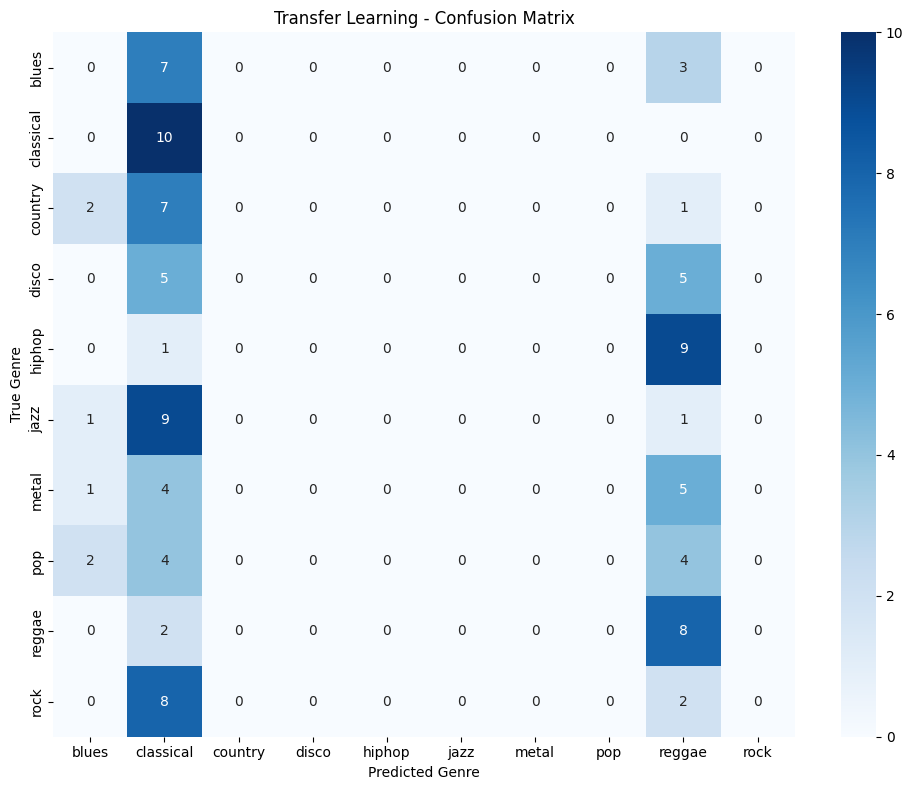


Detailed Classification Report:
              precision    recall  f1-score   support

       blues       0.00      0.00      0.00        10
   classical       0.18      1.00      0.30        10
     country       0.00      0.00      0.00        10
       disco       0.00      0.00      0.00        10
      hiphop       0.00      0.00      0.00        10
        jazz       0.00      0.00      0.00        11
       metal       0.00      0.00      0.00        10
         pop       0.00      0.00      0.00        10
      reggae       0.21      0.80      0.33        10
        rock       0.00      0.00      0.00        10

    accuracy                           0.18       101
   macro avg       0.04      0.18      0.06       101
weighted avg       0.04      0.18      0.06       101


FINAL RESULTS SUMMARY
Custom CNN Accuracy: 60.40%
Transfer Learning Accuracy: 17.82%
🏆 Custom CNN performed better!


c:\Program Files\Python38\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Program Files\Python38\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Program Files\Python38\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [8]:
# Run the improved training
if __name__ == "__main__":
    print("Starting improved music genre classification training...")
    print("Expected improvements:")
    print("- Training time reduced from hours to ~30-60 minutes")
    print("- Target accuracy: >80%")
    print("- Better model architectures and training strategies")
    print("\n" + "="*60)
    
    cnn_model, transfer_model, testing = train_improved_models()
    evaluate_models(cnn_model, transfer_model, testing)